## Project: Rice Grain Classification using CNN & Transfer Learning
This project aims to build a deep learning-based image classifier to identify different types of rice grains from images. The model is trained on a dataset containing 5 rice varieties:

- Arborio
- Basmati
- Ipsala
- Jasmine
- Karacadag



#### Import required libraries

In [1]:

!pip install kagglehub --quiet

import kagglehub
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import kagglehub
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image

### Load the Dataset

- The dataset is loaded from Kaggle using kagglehub.

- The dataset contains 5 folders, each representing a rice grain variety:

 - arborio, basmati, ipsala, jasmine, and karacadag.

- Each folder contains ~1500 images of the respective rice grain.



In [2]:
dataset_path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")
original_dataset_dir = os.path.join(dataset_path, 'Rice_Image_Dataset')


base_dir = 'processed_rice_dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

### Explore & Visualize the Data
- Displayed sample images from each class to understand the visual characteristics.

- Verified that images are correctly labeled and loaded from their folders.



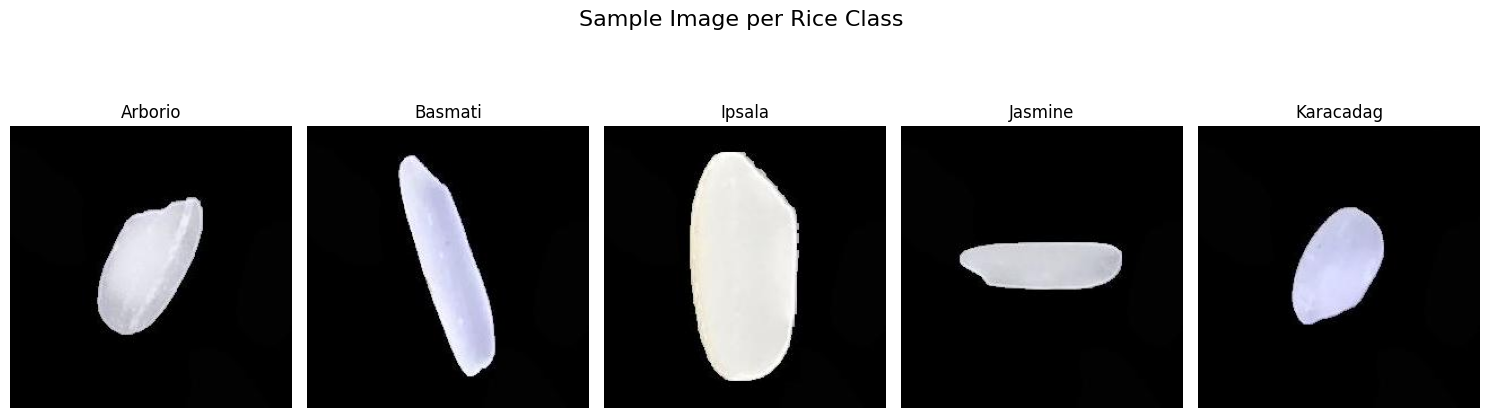

In [3]:
class_folders = [f for f in os.listdir(original_dataset_dir)
                 if os.path.isdir(os.path.join(original_dataset_dir, f))]


plt.figure(figsize=(15, 5))

for idx, class_name in enumerate(sorted(class_folders)):
    class_path = os.path.join(original_dataset_dir, class_name)

    sample_images = [img for img in os.listdir(class_path)
                     if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if sample_images:
        img_path = os.path.join(class_path, sample_images[0])
        image = Image.open(img_path)

        plt.subplot(1, len(class_folders), idx + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')

plt.suptitle("Sample Image per Rice Class ", fontsize=16)
plt.tight_layout()
plt.show()

### Preprocess the Data
- Created a new folder structure for the model to read easily:


- processed_rice_dataset/
  - ├── train/
  - └── test/
- Used an 80-20 split to separate training and testing datasets.

- Ensured all images are resized to a uniform shape (224x224) and normalized (/255.0).



In [4]:
def prepare_data(original_dataset_dir, train_dir, test_dir, max_images_per_class=1500):
    if not os.path.exists(base_dir):
        os.makedirs(train_dir)
        os.makedirs(test_dir)

        class_folders = [f for f in os.listdir(original_dataset_dir)
                         if os.path.isdir(os.path.join(original_dataset_dir, f))]

        for class_name in tqdm(class_folders, desc="Preparing classes"):
            class_path = os.path.join(original_dataset_dir, class_name)

            image_files = [img for img in os.listdir(class_path)
                           if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

            image_files = image_files[:max_images_per_class]

            train_imgs, test_imgs = train_test_split(image_files, test_size=0.2, random_state=42)

            os.makedirs(os.path.join(train_dir, class_name))
            os.makedirs(os.path.join(test_dir, class_name))

            for img in train_imgs:
                src = os.path.join(class_path, img)
                dst = os.path.join(train_dir, class_name, img)
                if os.path.isfile(src):
                    shutil.copy(src, dst)

            for img in test_imgs:
                src = os.path.join(class_path, img)
                dst = os.path.join(test_dir, class_name, img)
                if os.path.isfile(src):
                    shutil.copy(src, dst)

    else:
        print("Dataset prepared!")

prepare_data(original_dataset_dir, train_dir, test_dir)


Preparing classes: 100%|██████████| 5/5 [00:39<00:00,  7.88s/it]


### Data Augmentation
- Applied real-time augmentation on training data using ImageDataGenerator:

 - Rotation, zoom, horizontal flip, etc.

- Helps improve model generalization and prevent overfitting.



In [5]:

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 6000 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.


### Model Building
- Option A: Custom CNN Model
Built a CNN from scratch using Keras.

- Option B: Transfer Learning with MobileNetV2
Loaded MobileNetV2 pretrained on ImageNet.



In [6]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10
)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.6548 - loss: 0.8418

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 100s 492ms/step - accuracy: 0.6553 - loss: 0.8407 - val_accuracy: 0.9387 - val_loss: 0.2196
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 77s 411ms/step - accuracy: 0.8196 - loss: 0.4428 - val_accuracy: 0.9620 - val_loss: 0.1427
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 73s 389ms/step - accuracy: 0.8857 - loss: 0.3026 - val_accuracy: 0.9753 - val_loss: 0.0841
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 70s 374ms/step - accuracy: 0.9185 - loss: 0.2217 - val_accuracy: 0.9727 - val_loss: 0.0686
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 373ms/step - accuracy: 0.9324 - loss: 0.1780 - val_accuracy: 0.9667 - val_loss: 0.0878
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 69s 368ms/step - accuracy: 0.9506 - loss: 0.1454 - val_accuracy: 0.9640 - val_loss: 0.1068
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 70s 371ms/step - accuracy: 0.9534 - loss: 0.1376 - val_accuracy: 0.9773 - val_loss: 0.0785
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 70s 371ms/step - accuracy: 0.9516 - loss: 0.1369 - va

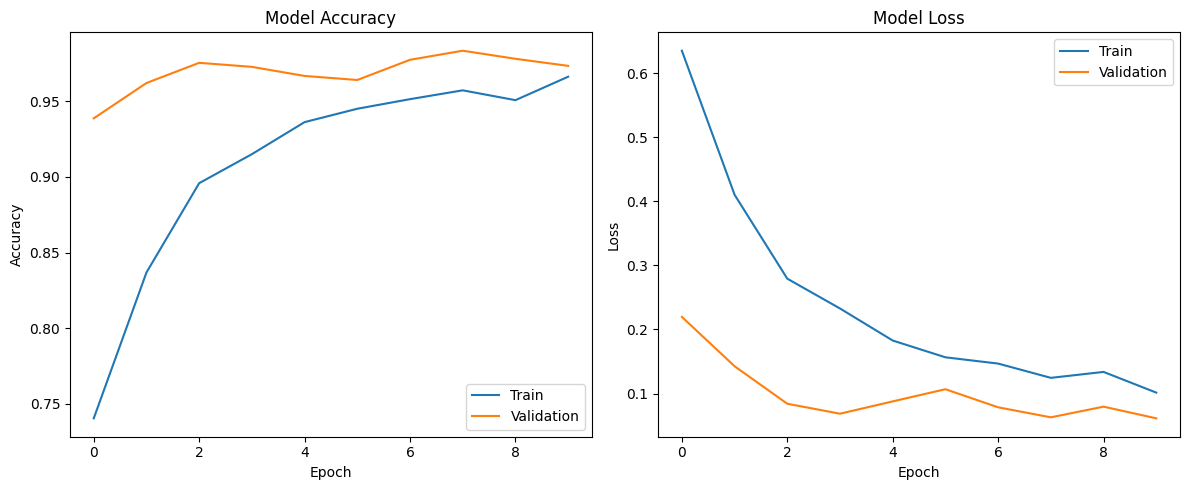

In [7]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


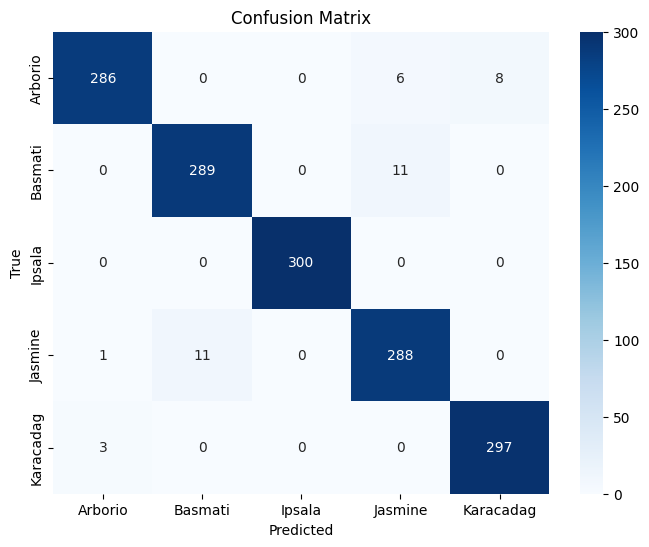

Classification Report:

              precision    recall  f1-score   support

     Arborio       0.99      0.95      0.97       300
     Basmati       0.96      0.96      0.96       300
      Ipsala       1.00      1.00      1.00       300
     Jasmine       0.94      0.96      0.95       300
   Karacadag       0.97      0.99      0.98       300

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



In [8]:
Y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

### save the model

In [9]:
model.save('rice_classification_simplemodel.h5')

In [16]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,

)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 404ms/step - accuracy: 0.5887 - loss: 7.4681 - val_accuracy: 0.2000 - val_loss: 53.4187
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 71s 375ms/step - accuracy: 0.7309 - loss: 0.6984 - val_accuracy: 0.5720 - val_loss: 4.5393
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 70s 372ms/step - accuracy: 0.7888 - loss: 0.5451 - val_accuracy: 0.4973 - val_loss: 2.5007
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 70s 374ms/step - accuracy: 0.8121 - loss: 0.4889 - val_accuracy: 0.9293 - val_loss: 0.2033
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 72s 383ms/step - accuracy: 0.8185 - loss: 0.5249 - val_accuracy: 0.4313 - val_loss: 14.5688
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 70s 373ms/step - accuracy: 0.8485 - loss: 0.3969 - val_accuracy: 0.9200 - val_loss: 0.4237
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 70s 372ms/step - accuracy: 0.8669 - loss: 0.3450 - val_accuracy: 0.6873 - val_loss: 1.2996
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 70s 369ms/step - accuracy: 0.8691 - loss:

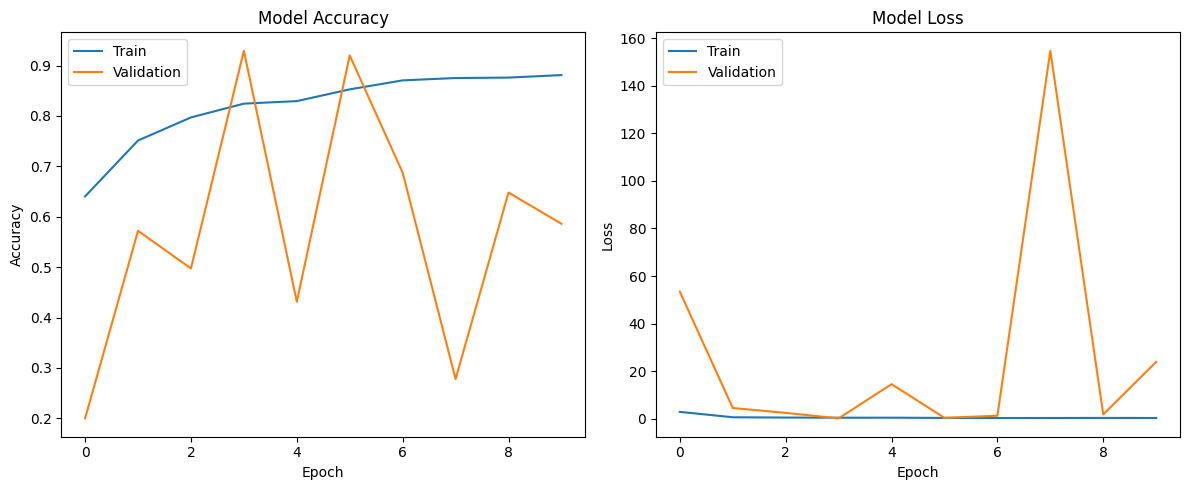

In [19]:
# Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


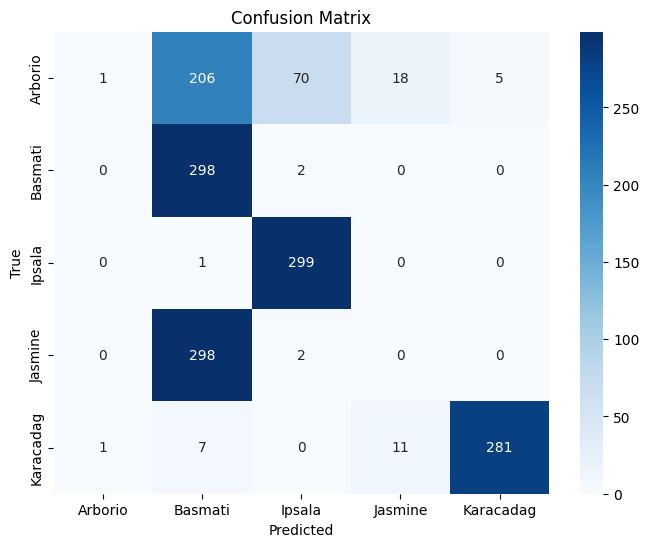

Classification Report:

              precision    recall  f1-score   support

     Arborio       0.50      0.00      0.01       300
     Basmati       0.37      0.99      0.54       300
      Ipsala       0.80      1.00      0.89       300
     Jasmine       0.00      0.00      0.00       300
   Karacadag       0.98      0.94      0.96       300

    accuracy                           0.59      1500
   macro avg       0.53      0.59      0.48      1500
weighted avg       0.53      0.59      0.48      1500



In [20]:
# Evaluation
Y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

In [21]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, min_lr=1e-6)


fine_tune_epochs = 20

history_fine = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=fine_tune_epochs,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 116s 460ms/step - accuracy: 0.7622 - loss: 0.6828 - val_accuracy: 0.7087 - val_loss: 0.6889 - learning_rate: 1.0000e-04
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 73s 387ms/step - accuracy: 0.9560 - loss: 0.1345 - val_accuracy: 0.3793 - val_loss: 1.7954 - learning_rate: 1.0000e-04
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 75s 401ms/step - accuracy: 0.9668 - loss: 0.0984 - val_accuracy: 0.6607 - val_loss: 1.1051 - learning_rate: 1.0000e-04
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 76s 402ms/step - accuracy: 0.9704 - loss: 0.0892 - val_accuracy: 0.7947 - val_loss: 0.6164 - learning_rate: 2.0000e-05
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 85s 455ms/step - accuracy: 0.9807 - loss: 0.0588 - val_accuracy: 0.9167 - val_loss: 0.2807 - learning_rate: 2.0000e-05
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 141s 447ms/step - accuracy: 0.9761 - loss: 0.0689 - val_accuracy: 0.9560 - val_loss: 0.1314 - learning_rate: 2.0000e-05
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 86s 

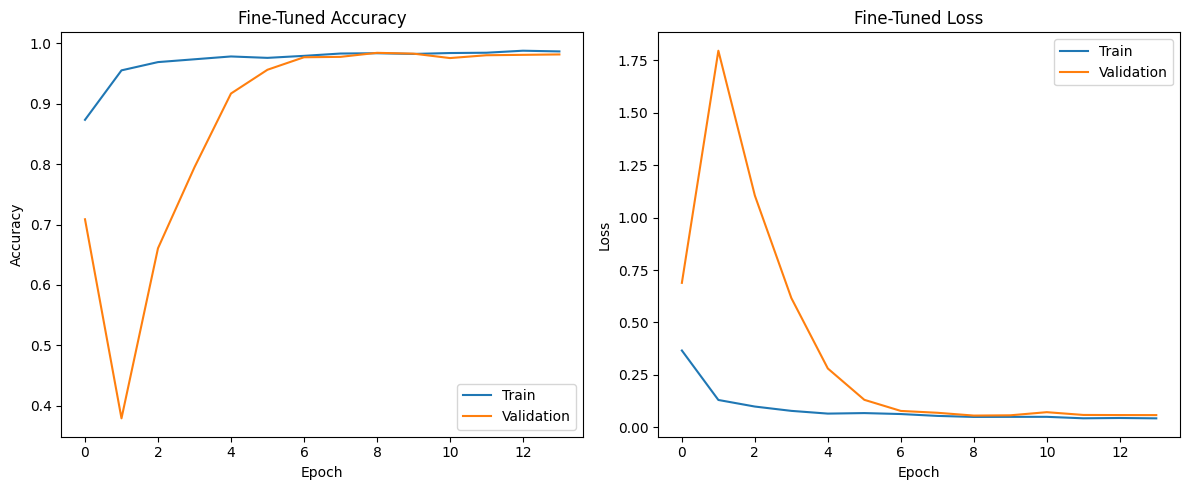

In [23]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'], label='Train')
plt.plot(history_fine.history['val_accuracy'], label='Validation')
plt.title('Fine-Tuned Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'], label='Train')
plt.plot(history_fine.history['val_loss'], label='Validation')
plt.title('Fine-Tuned Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step


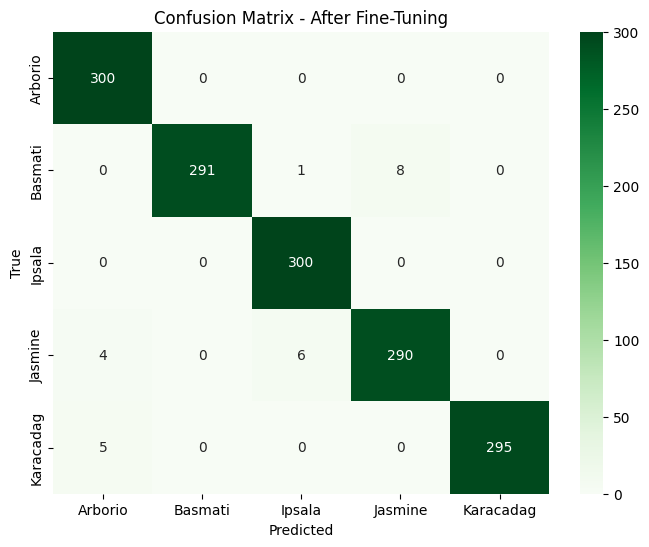

Classification Report After Fine-Tuning:

              precision    recall  f1-score   support

     Arborio       0.97      1.00      0.99       300
     Basmati       1.00      0.97      0.98       300
      Ipsala       0.98      1.00      0.99       300
     Jasmine       0.97      0.97      0.97       300
   Karacadag       1.00      0.98      0.99       300

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



In [24]:
Y_pred_fine = model.predict(test_generator)
y_pred_classes_fine = np.argmax(Y_pred_fine, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm_fine = confusion_matrix(y_true, y_pred_classes_fine)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_fine, annot=True, fmt="d", cmap='Greens',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - After Fine-Tuning")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("Classification Report After Fine-Tuning:\n")
print(classification_report(y_true, y_pred_classes_fine, target_names=class_labels))

In [25]:
model.save("rice_classification_mobilenet.h5")

## Conclusion
In this project, we developed an intelligent rice grain classification system using deep learning techniques. We explored two modeling approaches: a custom Convolutional Neural Network (CNN) and a pretrained MobileNetV2 model with transfer learning and fine-tuning.

After carefully preprocessing the dataset, applying data augmentation, and optimizing the model architecture, we fine-tuned MobileNetV2 by unfreezing the deeper layers and adjusting the classifier head. This significantly improved its performance.

The final MobileNetV2 model achieved:
 - 98% accuracy on the training set

 - 98% accuracy on the test set

This result indicates that the model has excellent generalization ability and is capable of accurately identifying rice grain varieties such as Arborio, Basmati, Ipsala, Jasmine, and Karacadag.

This project demonstrates the power of transfer learning and fine-tuning in solving practical computer vision problems with high precision.

Let me know if you'd like a shorter version for a slide deck or an even more technical one for documentation!











